# qubit-resonator system

## 哈密顿量
$$
H = \omega_r a^\dagger a - \frac{1}{2}\omega_q \sigma_z + g(a^\dagger a)\sigma_x
$$

## 色散区间
$\Delta = \omega_r - \omega_p \gg g$
### 哈密顿量
$$
H = \omega_r a^\dagger a - \frac{1}{2}\omega_q \sigma_z + \chi(a^\dagger a + \frac{1}{2})\sigma_z
$$
这里 $\chi = g^2/\Delta$

In [1]:
# 导入必要的包
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import *

In [2]:
# 定义相关常数
N = 20 # resonator 的能级空间

omega_r = 2.0 * 2 * np.pi
omega_q = 3.0 * 2 * np.pi

# 色散系数
chi = 0.025 * 2 * np.pi

delta = np.abs(omega_r - omega_q)
g = np.sqrt(delta * chi) # 耦合强度

In [3]:
delta, g

(6.283185307179586, 0.99345882657961)

In [4]:
# 定义算符并构建哈密顿量
# 谐振腔算符
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# 原子算符
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

I = tensor(qeye(N), qeye(2))

In [30]:
# 构建哈密顿量
H = omega_r * (nc) + 0.5 * omega_q * sz + chi * (nc + I/2) * sz

In [6]:
# 定义初态
psi0 = tensor(coherent(N, np.sqrt(4)), (basis(2,0) + basis(2,1)).unit())

## 求解时间演化

In [7]:
tlist = np.linspace(0, 250, 1000)

In [8]:
res = mesolve(H, psi0, tlist, [], [], options=Odeoptions(nsteps=5000))

## 可视化结果——粒子数

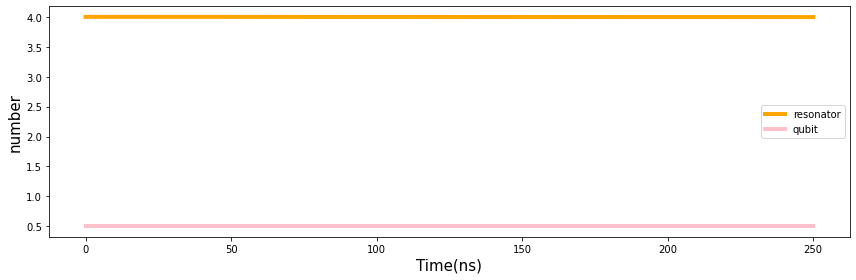

In [9]:
nc_ls = expect(nc, res.states)
nq_ls = expect(nq, res.states)

fig, ax = plt.subplots(1,1, sharex=True, figsize=(12,4))

ax.plot(tlist, nc_ls, color='orange', label='resonator', linewidth=4)
ax.plot(tlist, nq_ls, color='pink', label='qubit', linewidth=4)
ax.set_xlabel('Time(ns)', fontsize=15)
ax.set_ylabel('number', fontsize=15)
ax.legend(loc=0)

fig.tight_layout()

因为是非共振状态，所以几乎没有粒子数交换

In [10]:
# 正交算符的演化，快速振荡
xc_ls = expect(xc, res.states)

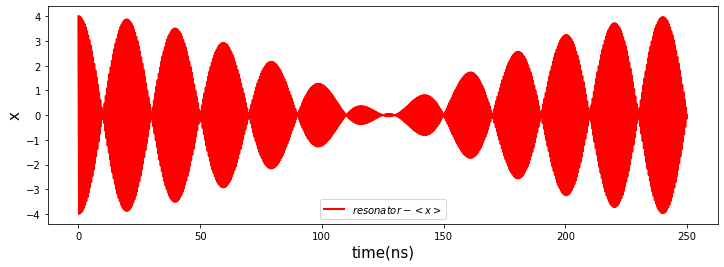

In [11]:
# 画图
fig, ax = plt.subplots(1,1, sharex=True, figsize=(12, 4))

ax.plot(tlist, xc_ls, 'r', linewidth=2, label='$resonator-<x>$')
ax.set_ylabel('x', fontsize=15)
ax.set_xlabel('time(ns)', fontsize=15)

ax.legend()


## 谐振腔的关联函数

In [44]:
tlist = np.linspace(0, 1000, 10000)

In [32]:
corr_vec = correlation(H, psi0, None, tlist, [], a.dag(), a)

D:\conda\envs\qutip_env\lib\site-packages\qutip\correlation.py:748: FutureWarning: correlation() now legacy, please use correlation_2op_2t()
  warn("correlation() now legacy, please use correlation_2op_2t()",


(0.0, 50.0)

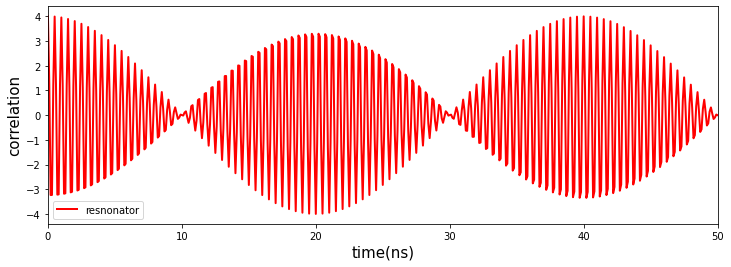

In [33]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(12,4))

ax.plot(tlist, np.real(corr_vec), 'r', linewidth=2, label='resnonator')
ax.set_xlabel('time(ns)', fontsize=15)
ax.set_ylabel('correlation', fontsize=15)
ax.legend()
ax.set_xlim(0, 50)

## 谐振腔频谱

In [34]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

(1.5, 2.5)

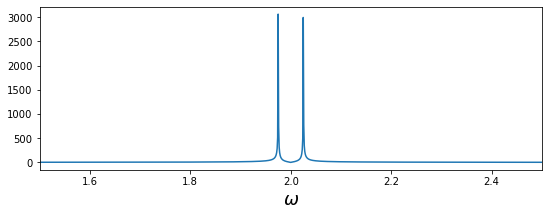

In [39]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(9,3))

ax.plot(w/(2*np.pi), np.abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)
ax.set_xlim(omega_r/(2*np.pi)-.5, omega_r/(2*np.pi)+.5)

(-2.0, 2.0)

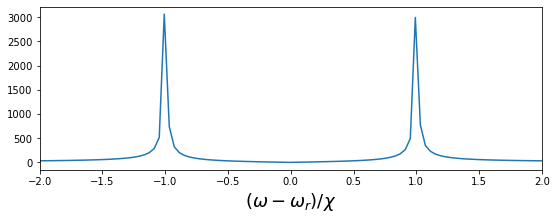

In [40]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot((w-omega_r)/chi, abs(S))
ax.set_xlabel(r'$(\omega-\omega_r)/\chi$', fontsize=18)
ax.set_xlim(-2,2)

## qubit 的关联函数

In [45]:
corr_vec = correlation_2op_1t(H, psi0, tlist, [], sx, sx)

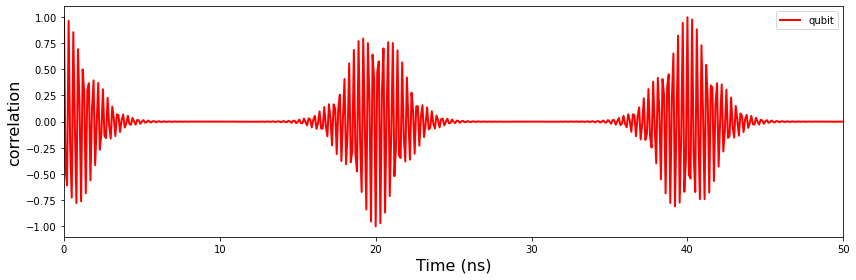

In [46]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12,4))

ax.plot(tlist, np.real(corr_vec), 'r', linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0,50)
fig.tight_layout()

## qubit 的频谱

In [47]:
w, S = spectrum_correlation_fft(tlist, corr_vec)

Text(0.5, 0, '$\\omega$')

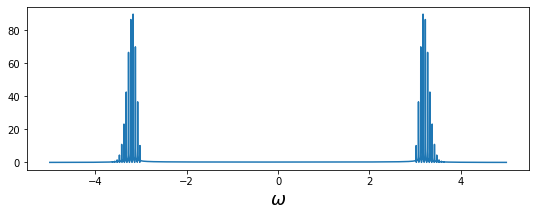

In [49]:
fig, ax = plt.subplots(figsize=(9,3))
ax.plot(w / (2 * np.pi), np.abs(S))
ax.set_xlabel(r'$\omega$', fontsize=18)

(-0.5, 20.0)

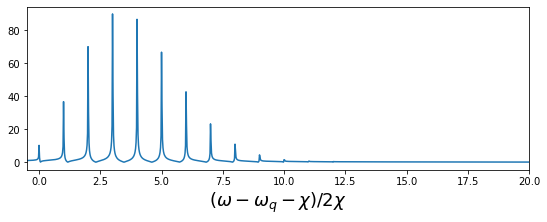

In [51]:
ig, ax = plt.subplots(figsize=(9,3))
ax.plot((w - omega_q - chi) / (2 * chi), abs(S))
ax.set_xlabel(r'$(\omega - \omega_q - \chi)/2\chi$', fontsize=18)
ax.set_xlim(-.5, N)

In [52]:
rho_cavity = ptrace(res.states[-1], 0)

Text(0, 0.5, 'Occupation probability')

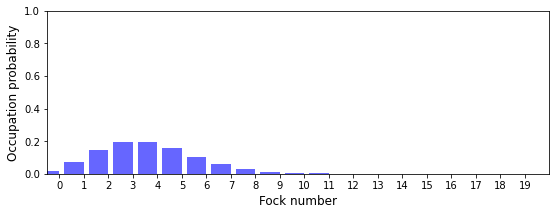

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(9,3))

axes.bar(np.arange(0, N)-.4, np.real(rho_cavity.diag()), color="blue", alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(np.arange(0, N))
axes.set_xlabel('Fock number', fontsize=12)
axes.set_ylabel('Occupation probability', fontsize=12)

### 腔不再是相干态，而是相干态的叠加态

Text(0, 0.5, 'Re $\\alpha$')

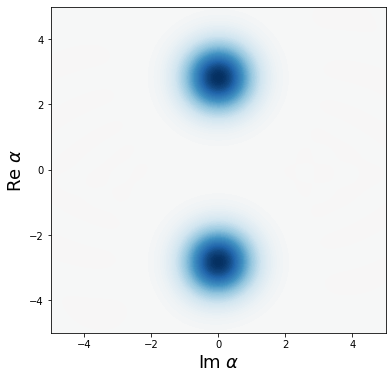

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

xvec = np.linspace(-5,5,200)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=plt.get_cmap('RdBu'))
axes.set_xlabel(r'Im $\alpha$', fontsize=18)
axes.set_ylabel(r'Re $\alpha$', fontsize=18)